Import some libraries
--

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from helper import *

Load the relevant simulation result data
--

In [2]:
label= "2021-07-22-runs/run"
gid= "0.0"
pop= "PNs"
N= 800
nglo= N//5
spike_t= np.load(label+"_hom_"+gid+"_"+pop+"_spike_t.npy")
spike_ID= np.load(label+"_hom_"+gid+"_"+pop+"_spike_ID.npy")
t_total= spike_t[-1]

In [3]:
mlabel= "2021-07-22-runs/run_hom_0.0_odors_0_1"
mspike_t= np.load(mlabel+"_"+pop+"_spike_t.npy")
mspike_ID= np.load(mlabel+"_"+pop+"_spike_ID.npy")
mt_total= mspike_t[-1]

Define a couple of extra helper functions
--
force_aspect to force the aspect ratio of imshow plots

glo_avg to take the average of data across all entities belonging to the same glomerulus/OR type

In [4]:
def force_aspect(ax,aspect):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

In [5]:
def glo_avg(sdf: np.ndarray, n):
    nglo= sdf.shape[1]//n
    gsdf= np.zeros((sdf.shape[0],nglo))
    for i in range(nglo):
        gsdf[:,i]= np.mean(sdf[:,n*i:n*(i+1)],axis=1)
    return gsdf

Core processing of the data
--

In [15]:
trial_time= 12000.0
cnum= 25
batch_t= cnum*trial_time
wds= int(t_total//batch_t) # corresponds to number of odours presented / number of batches
li= 0
sigma_sdf= 100
dt_sdf= 1
mxsdfs= np.zeros((wds,cnum))
mnsdfs= np.zeros((wds,cnum))
mxid= np.zeros(wds, dtype=int)
mx= np.zeros(wds)
amnsdf=np.zeros((wds,cnum,160))
for i in range(wds):
    meansdf= np.zeros(nglo)
    gsdfs= []
    for j in range(cnum):
        left= i*batch_t+j*trial_time
        right= left+trial_time
        while li < len(spike_t) and spike_t[li] < left:
            li+= 1
        ri= li
        while ri < len(spike_t) and spike_t[ri] < right:
            ri+= 1
        lsdfs= make_sdf(spike_t[li:ri], spike_ID[li:ri], np.arange(0,N), left-3*sigma_sdf, right+3*sigma_sdf, dt_sdf, sigma_sdf)
        gsdfs.append(glo_avg(lsdfs,5))
        meansdf+= np.mean(gsdfs[-1][3000:6000,:],axis=0)
        amnsdf[i,j,:]= np.mean(gsdfs[-1][3000:6000,:],axis=0)
    mxid[i]= np.argmax(meansdf)  # this is the strongest glomerulus over all concentrations
    mx[i]= np.amax(meansdf)
    for k in range(cnum):
        mxsdfs[i,k]= np.amax(gsdfs[k][:,mxid[i]],axis=0)
        mnsdfs[i,k]= np.mean(gsdfs[k][3000:,mxid[i]],axis=0)
mxmx= np.argmax(mx)

Also look at the "monotonicity"
---
Here mono is the difference between the maximal value of the time averaged SDF response and the value at maximal concentration. If mono is high, the meanSDF-concentration curve has a local maximum at a lower concentration. If it is zero, the maximum occurs at the highest concentration, which we interpret as a monotonic response.

In [7]:
mono= np.zeros(wds)
for i in range(wds):
    mono[i]= (np.amax(mnsdfs[i,:])-mnsdfs[i,-1])/np.mean(mnsdfs[i,:])
mxmono= np.argmin(mono)

In [8]:
print("Strongest odor is {}.".format(mxmx))
print("Most monotonic odor is {}.".format(mxmono))

Strongest odor is 35.
Most monotonic odor is 13.


Do some diagnostics and diagnostic plots
---

[ 25 143  35   3   3  69  15 126   5  46 145 131 150 121 138 122 139  33
  13 141  63 150  10  35   9  48  33  64 126  37   2 117 132 151  14 150
  17  24 139 141   6 141  14 141 150  90  98  95  14  42  52  26 121  69
  39 122 114 141 122 139  32 144 111 139  48  43 143  86  28  33  61  95
  65  11  50   6  85 118  36  98  92   6 111  54 152 131  85  25  12 143
  35  28  24  82 137 148  86   6  13 128]
(100, 160, 2)


<ipython-input-9-80fa12da49f1>:30: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.reshape(np.log(odors[:,:,0]),(nodor,160)),interpolation="None")


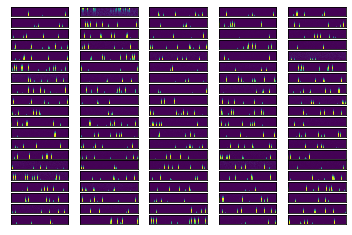

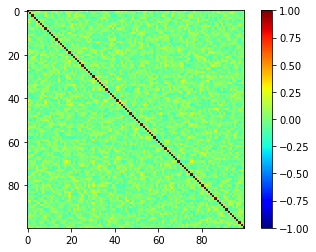

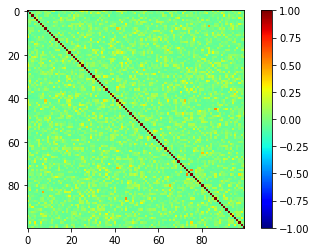

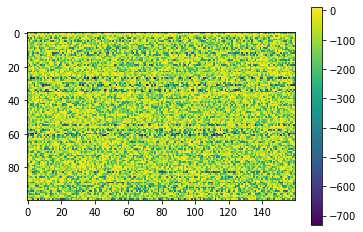

In [9]:
nodor= wds
fig, ax= plt.subplots(20,5)
for i in range(20):
    for j in range(5):
        n= i*5+j
        if n < wds:
            ax[i,j].imshow(np.reshape(amnsdf[n,:,:],(cnum,160)),interpolation="None")
            ax[i,j].set_yticks([])
            ax[i,j].set_xticks([])
print(mxid)
cca= np.zeros((nodor,nodor))
for i in range(nodor):
    for j in range(nodor):
        cc= np.corrcoef(np.reshape(amnsdf[i,-1,:],160),np.reshape(amnsdf[j,-1,:],160))
        cca[i,j]= cc[0,1]
plt.figure()
plt.imshow(cca,cmap="jet", vmin= -1, vmax=1,interpolation="None")
plt.colorbar()
odors= np.load("2021-07-22-runs/run_odors.npy")
print(odors.shape)
for i in range(nodor):
    for j in range(nodor):
        cc= np.corrcoef(np.reshape(odors[i,:,0],160),np.reshape(odors[j,:,0],160))
        cca[i,j]= cc[0,1]
plt.figure()
plt.imshow(cca,cmap="jet", vmin= -1, vmax=1,interpolation="None")
plt.colorbar()

plt.figure()
plt.imshow(np.reshape(np.log(odors[:,:,0]),(nodor,160)),interpolation="None")
plt.colorbar()

Make line plots of the max and mean responses as a function of concentration
---

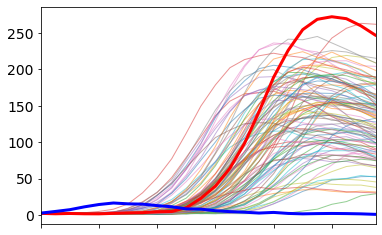

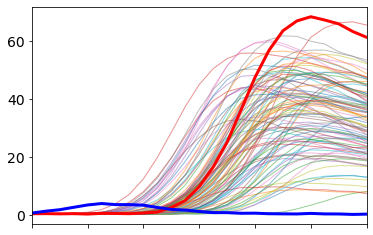

In [19]:
plt.rc('font', size=14) #controls default text size
plt.figure()
td= np.transpose(mxsdfs)
if wds > 2:
    plt.plot(td[:,2:],lw=1,alpha=0.5)
plt.plot(td[:,0],'r',lw=3)
plt.plot(td[:,1],'b',lw=3)
ax= plt.gca()
ax.set_xticks(range(0,cnum,4))
ax.set_xticklabels([])
ax.set_xlim((0,23))
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
#plt.yscale("log")
#ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*0.8)
plt.savefig("max_sdfs.png",dpi=300)
plt.figure()
td= np.transpose(mnsdfs)
if wds > 2:
    plt.plot(td[:,2:],lw=1.0,alpha=0.5)
plt.plot(td[:,0],'r',lw=3)
plt.plot(td[:,1],'b',lw=3)
ax= plt.gca()
ax.set_xlim((0,23))
ax.set_xticks(range(0,cnum,4))
ax.set_xticklabels([])
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
#plt.yscale("log")
#ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*0.8)
plt.savefig("mean_sdfs.png",dpi=300)

Display Responses to binary mixtures of the "geosmin odor" and the "IAA odor"
--

In [16]:
li= 0
mwds= int(mt_total//batch_t) # corresponds to number of odours presented / number of batches
mmxsdfs= np.zeros((mwds,cnum))
mmnsdfs= np.zeros((mwds,cnum))
aimn= np.zeros((mwds,cnum,nglo))
for i in range(mwds):
    for j in range(cnum):
        left= i*batch_t+j*trial_time
        right= left+trial_time
        while li < len(mspike_t) and mspike_t[li] < left:
            li+= 1
        ri= li
        while ri < len(mspike_t) and mspike_t[ri] < right:
            ri+= 1
        lsdfs= make_sdf(mspike_t[li:ri], mspike_ID[li:ri], np.arange(0,N), left-3*sigma_sdf, right+3*sigma_sdf, dt_sdf, sigma_sdf)
        gsdfs=glo_avg(lsdfs,5)
        aimn[i,j,:]= np.reshape(np.mean(gsdfs[3000:6000,:],axis=0),(1,1,-1))
        mmxsdfs[i,j]= np.amax(np.amax(gsdfs))
        mmnsdfs[i,j]= np.amax(np.mean(gsdfs[3000:6000,:],axis=0))

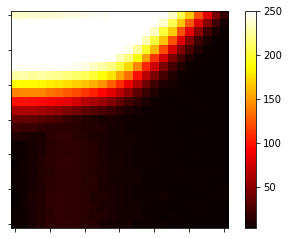

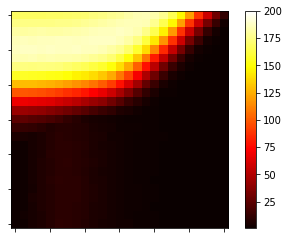

In [17]:
plt.figure()
plt.imshow(mmxsdfs,cmap="hot",vmax=250,interpolation="None")
ax= plt.gca()
ax.invert_yaxis()
ax.set_xticks(range(0,cnum,4))
ax.set_xticklabels([])
ax.set_yticks(range(0,cnum,4))
ax.set_yticklabels([])
plt.colorbar()
plt.savefig("mix_max_map.png",dpi=300)
plt.figure()
plt.imshow(mmnsdfs,cmap="hot",vmax=200,interpolation="None")
ax= plt.gca()
ax.invert_yaxis()
ax.set_xticks(range(0,cnum,4))
ax.set_xticklabels([])
ax.set_yticks(range(0,cnum,4))
ax.set_yticklabels([])
plt.colorbar()
plt.savefig("mix_mean_map.png",dpi=300)

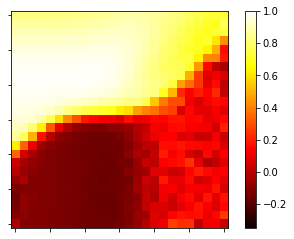

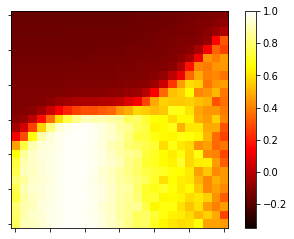

In [18]:
odors= np.load(label+"_odors.npy")
o1= 0
o2= 1
c= np.zeros((cnum,cnum))
for o in [o1, o2]:
    for i in range(cnum):
        for j in range(cnum):
            c[i,j]= np.corrcoef(np.reshape(aimn[i,j,:],-1),np.reshape(odors[o,:,0],-1))[0,1]

    plt.figure()
    plt.imshow(c,cmap="hot",vmin=-0.35, vmax= 1.0,interpolation="None")
    plt.gca().invert_yaxis()
    plt.colorbar()
    ax= plt.gca()
    ax.set_xticks(range(0,cnum,4))
    ax.set_xticklabels([])
    ax.set_yticks(range(0,cnum,4))
    ax.set_yticklabels([])
    plt.savefig("odor_"+str(o)+"_correl.png", dpi=300)